[Reference](https://medium.com/mlearning-ai/time-series-forecasting-while-considering-holidays-with-fbprophet-cccde95572e1)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

# import historical orders
DATAPATH = r'https://raw.githubusercontent.com/evanbudianto/forecasting-with-fbprophet/main/orders.csv'
df = pd.read_csv(DATAPATH, sep=';')

# correcting date format
df['order_date'] = pd.to_datetime(df['order_date'], format="%d/%m/%Y")

# set Order Date as index
df.set_index('order_date', inplace=True)


# import special dates
datapath_holidays = r'https://raw.githubusercontent.com/evanbudianto/forecasting-with-fbprophet/main/holidays.csv'
df_holidays = pd.read_csv(datapath_holidays, sep=';')

# correcting date format
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'], format="%d/%m/%Y")

# change columns name to meet prophet requirement
df_holidays.columns = ['holiday', 'ds']
df_holidays.head()

,holiday,ds
0,Double-Double Campaign,2020-01-01
1,Payday Sale,2020-01-25
2,Double-Double Campaign,2020-02-02
3,Payday Sale,2020-02-25
4,Double-Double Campaign,2020-03-03


In [12]:
!python -m pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached cmdstanpy-1.0.4-py3-none-any.whl (73 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8j1qyoah/p49o5o4w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8j1qyoah/gvskqbkq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10888', 'data', 'file=/tmp/tmp8j1qyoah/p49o5o4w.json', 'init=/tmp/tmp8j1qyoah/gvskqbkq.json', 'output', 'file=/tmp/tmpd9aa2wyx/prophet_model-20220821025543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


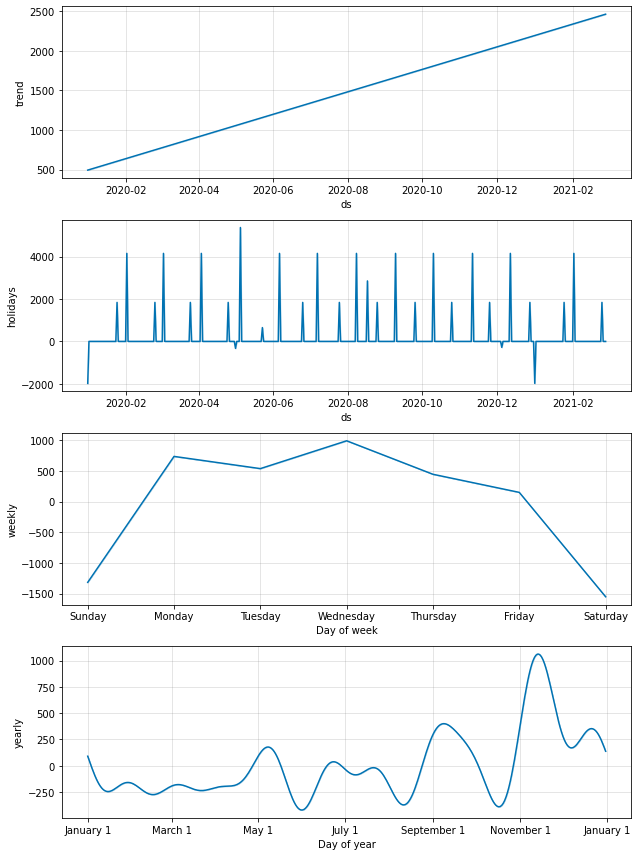

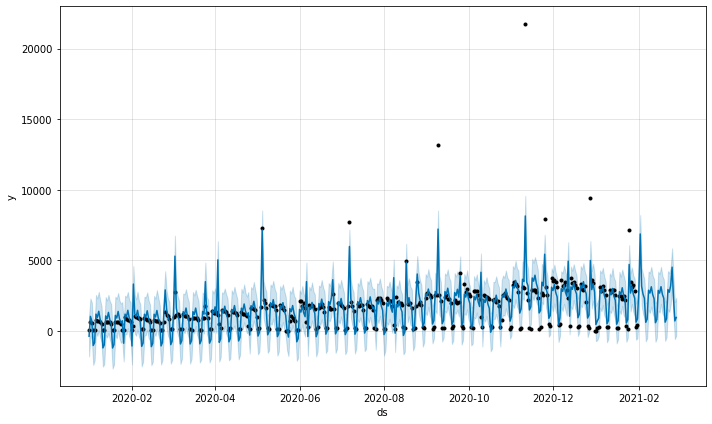

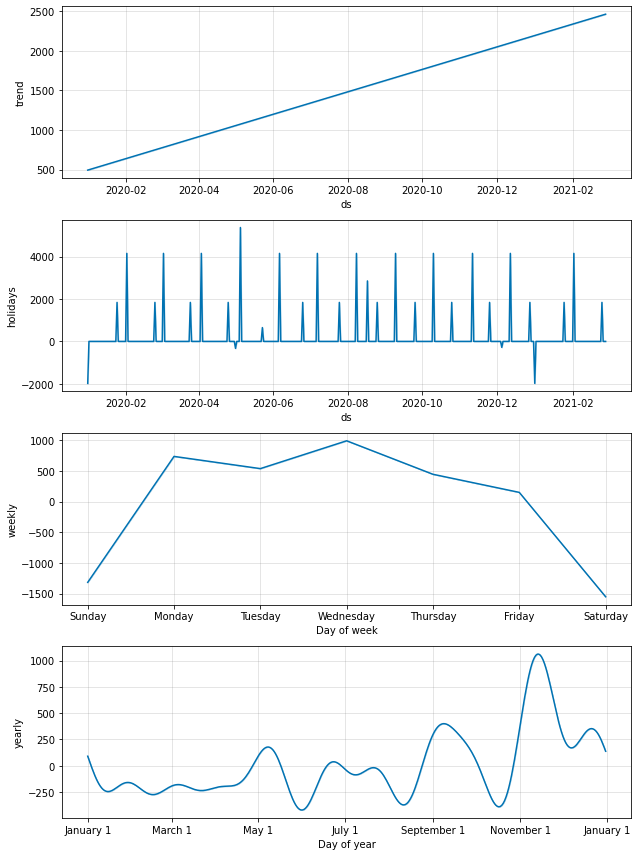

In [14]:
# import prophet
from prophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)


# Splitting train and test dataset. Test set is order data from February 2021.
df_train = df.loc[:'2021-01-31']
df_test = df.loc['2021-02-01':]

# take first column for modelling
df_train1 = df_train[['product_1']]

# put date index as column and change columns name for prophet
df_train1 = df_train1.reset_index()
df_train1.columns = ['ds', 'y']

# Defining model with yearly seasonality and holidays. Then fitting.
m = Prophet(daily_seasonality=False, yearly_seasonality=True, holidays = df_holidays)
m.fit(df_train1)

# Forecasting February 2021 orders
prediction_size = 28
future = m.make_future_dataframe(periods=prediction_size)
forecast = m.predict(future)

# plot forecast
m.plot(forecast)

# plot prophet components from model
m.plot_components(forecast)

MAPE 48.544095645478556
MAE 681.1183215868459


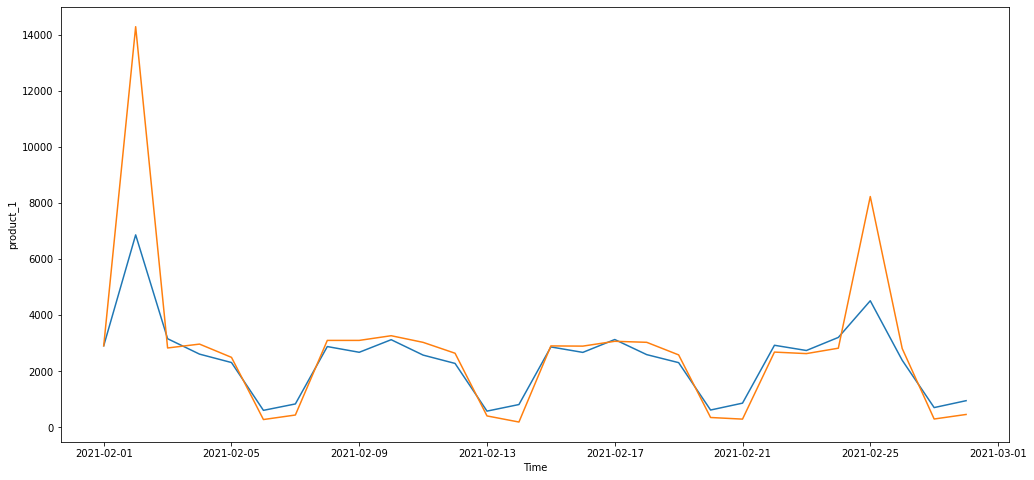

In [15]:
# function for comparing forecast and real data
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical)

cmp_df = make_comparison_dataframe(df[['product_1']], forecast)

# function for calculation MAPE and MAE
def calculate_forecast_errors(df, prediction_size, col):
    
    df = df.copy()
    
    df['e'] = df[col] - df['yhat']
    df['p'] = 100 * df['e'] / df[col]
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}
  
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size, 'product_1').items():
    print(err_name, err_value)
    
    
# plotting forecast vs real data
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'].loc['2021-02-01':])
#plt.plot(cmp_df['yhat_lower'])
#plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['product_1'].loc['2021-02-01':])
plt.xlabel('Time')
plt.ylabel('product_1')
plt.grid(False)
plt.show()

In [16]:
def predict_order(col, df_cast):
    # select column to be trained
    train = df_train[[col]]
    test = df_test[[col]]
    
    train = train.reset_index()
    train.columns = ['ds', 'y']
    
    # define model
    m = Prophet(daily_seasonality=False, yearly_seasonality=True, holidays = df_holidays)
    m.fit(train)
    
    # forecasting
    prediction_size = 28
    future = m.make_future_dataframe(periods=prediction_size)
    forecast = m.predict(future)
    
    #comparison
    cmp_df = make_comparison_dataframe(df[[col]], forecast)
    cmp_df.head()
    
    for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size, col).items():
        print(col, err_name, "%.2f" % err_value)
        
    df_x = forecast[['yhat']].tail(28).reset_index(drop=True)
    df_forecast[col] = pd.Series(df_x['yhat'])
    
    
# listing all columns to be predicted
column_predict = ['product_1', 'product_2', 'product_3', 'product_4',
       'product_5', 'product_6']

# define dataframe for forecast result
df_forecast = df.reset_index()
df_forecast = df_forecast[['order_date']]
#df_forecast.columns = ['ds']
df_forecast = df_forecast[-28:].reset_index(drop=True)

# running forecasting for all columns
for col in column_predict:
    predict_order(col, df_forecast)
    
# sum all order from products to total_order column
df_forecast['total_order'] = df_forecast[column_predict].sum(axis=1)

# rearrange columns
cols = ['order_date', 'total_order', 'product_1', 'product_2', 'product_3', 'product_4',
       'product_5', 'product_6']
df_forecast = df_forecast[cols]

# output file
df_forecast.to_csv(r'forecast.csv', index=False, sep=',')

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8j1qyoah/32ryqvag.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8j1qyoah/4b_07o7y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13594', 'data', 'file=/tmp/tmp8j1qyoah/32ryqvag.json', 'init=/tmp/tmp8j1qyoah/4b_07o7y.json', 'output', 'file=/tmp/tmpjooaczh4/prophet_model-20220821025604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:56:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:56:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8j1qyoah/ltmx_p8e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8j1qyoah/wewnksfg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-pack

product_1 MAPE 48.54
product_1 MAE 681.12


02:56:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8j1qyoah/c7w52r5z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8j1qyoah/oqqsr9y8.json


product_2 MAPE 50.39
product_2 MAE 840.83


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16230', 'data', 'file=/tmp/tmp8j1qyoah/c7w52r5z.json', 'init=/tmp/tmp8j1qyoah/oqqsr9y8.json', 'output', 'file=/tmp/tmpfgjr55w9/prophet_model-20220821025622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:56:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:56:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8j1qyoah/nrqggs2a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8j1qyoah/7dyww5gl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9679', 'data', 'file=/tmp/tmp8j1qyoah/nrqggs2a.json', 'init=/tmp/t

product_3 MAPE 16.08
product_3 MAE 663.61


02:56:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8j1qyoah/apuocuws.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8j1qyoah/ztnjtd31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71725', 'data', 'file=/tmp/tmp8j1qyoah/apuocuws.json', 'init=/tmp/tmp8j1qyoah/ztnjtd31.json', 'output', 'file=/tmp/tmpl7z2ka0p/prophet_model-20220821025635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:56:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:56:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


product_4 MAPE 17.23
product_4 MAE 667.57


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8j1qyoah/7q_cuasn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8j1qyoah/qru2wylb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70817', 'data', 'file=/tmp/tmp8j1qyoah/7q_cuasn.json', 'init=/tmp/tmp8j1qyoah/qru2wylb.json', 'output', 'file=/tmp/tmpdurdj0pz/prophet_model-20220821025638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:56:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:56:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


product_5 MAPE 13.57
product_5 MAE 592.56
product_6 MAPE 79.91
product_6 MAE 1485.04
